In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [2]:
df=pd.read_csv('/content/tcga_cohort.csv')
df
df.info()
#df.corr()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   cohort                10200 non-null  object
 1   Tumor_Sample_Barcode  10200 non-null  object
 2   total                 10200 non-null  int64 
 3   site                  10200 non-null  object
dtypes: int64(1), object(3)
memory usage: 318.9+ KB


Enter full TCGA Tumor Sample Barcode: TCGA-C5-A7CJ-01A-11D-A32I-09
Predicted Site (Max Voting): Cervix (Votes: 59)


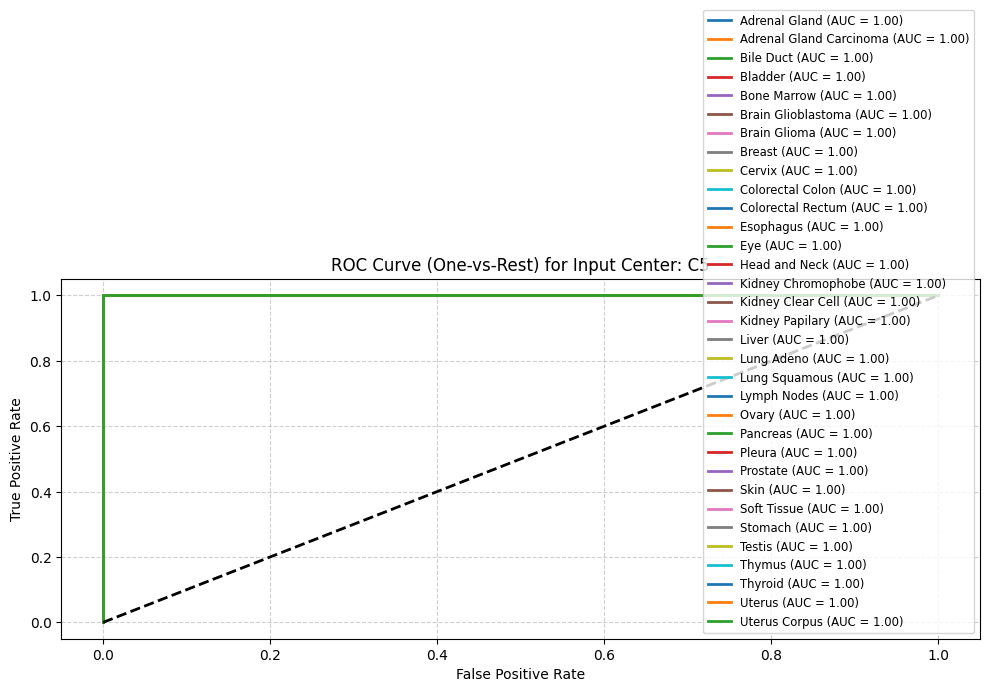

In [3]:

# 2. Extract center_code from barcode
df['center_code'] = df['Tumor_Sample_Barcode'].str.extract(r'TCGA-([A-Z0-9]+)-')

# 3. Drop missing values
df.dropna(subset=['center_code', 'site'], inplace=True)

# 4. Encode center_code as feature (OneHot)
X = pd.get_dummies(df['center_code'])

# 5. Encode target site label
y = df['site']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 6. Binarize target for ROC (multi-class)
y_bin = label_binarize(y_encoded, classes=range(len(label_encoder.classes_)))

# 7. Train classifier
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf.fit(X, y_bin)

# 8. Take user input
user_input = input("Enter full TCGA Tumor Sample Barcode: ").strip()
match = pd.Series(user_input).str.extract(r'TCGA-([A-Z0-9]+)-')
def predict_site_with_max_voting(input_barcode):
    # Extract center code from user input
    match = pd.Series(input_barcode).str.extract(r'TCGA-([A-Z0-9]+)-')

    if match.isna().any().any():
        return "Invalid TCGA barcode format."

    center_code = match.iloc[0, 0]

    # Filter rows with the same center code
    filtered_df = df[df['center_code'] == center_code]

    if filtered_df.empty:
        return f"No data found for center code: {center_code}"

    # Count occurrences of each site (simulate max voting)
    vote_counts = Counter(filtered_df['site'])

    # Get site with max votes
    most_common_site, count = vote_counts.most_common(1)[0]

    return f"Predicted Site (Max Voting): {most_common_site} (Votes: {count})"
print(predict_site_with_max_voting(user_input))

if not match.isna().any().any():
    center_code = match.iloc[0, 0]

    # Prepare input vector
    input_vector = pd.DataFrame([0]*X.shape[1], index=X.columns).T
    if center_code in X.columns:
        input_vector[center_code] = 1
    else:
        print(f"Unknown center code: {center_code}")
        exit()

    # Predict probabilities
    probs = clf.predict_proba(input_vector)[0]

    # Plot ROC curve (One-vs-Rest style)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(label_encoder.classes_)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], clf.decision_function(X)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all class ROC curves
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f"{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve (One-vs-Rest) for Input Center: {center_code}")
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

else:
    print("Invalid TCGA barcode format.")

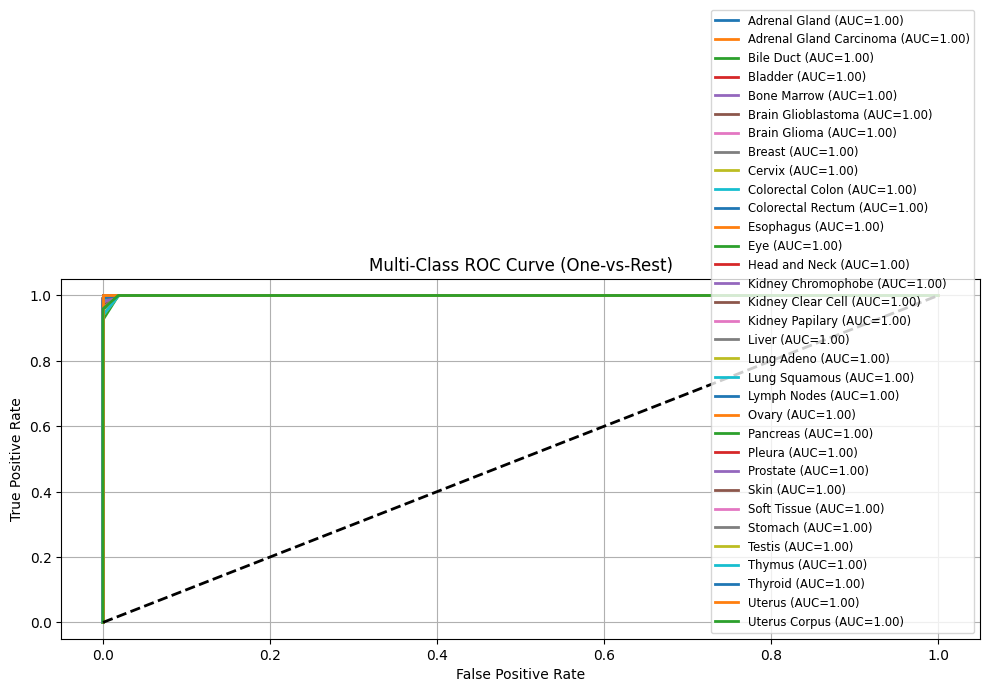

In [6]:
# Step 1: Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3, random_state=42)

# Step 2: Train classifier
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))
clf.fit(X_train, y_train)

# Step 3: Get decision function or predict_proba
y_score = clf.decision_function(X_test)

# Step 4: Plot ROC curve per class
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 5: Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for i in range(y_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{label_encoder.classes_[i]} (AUC={roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


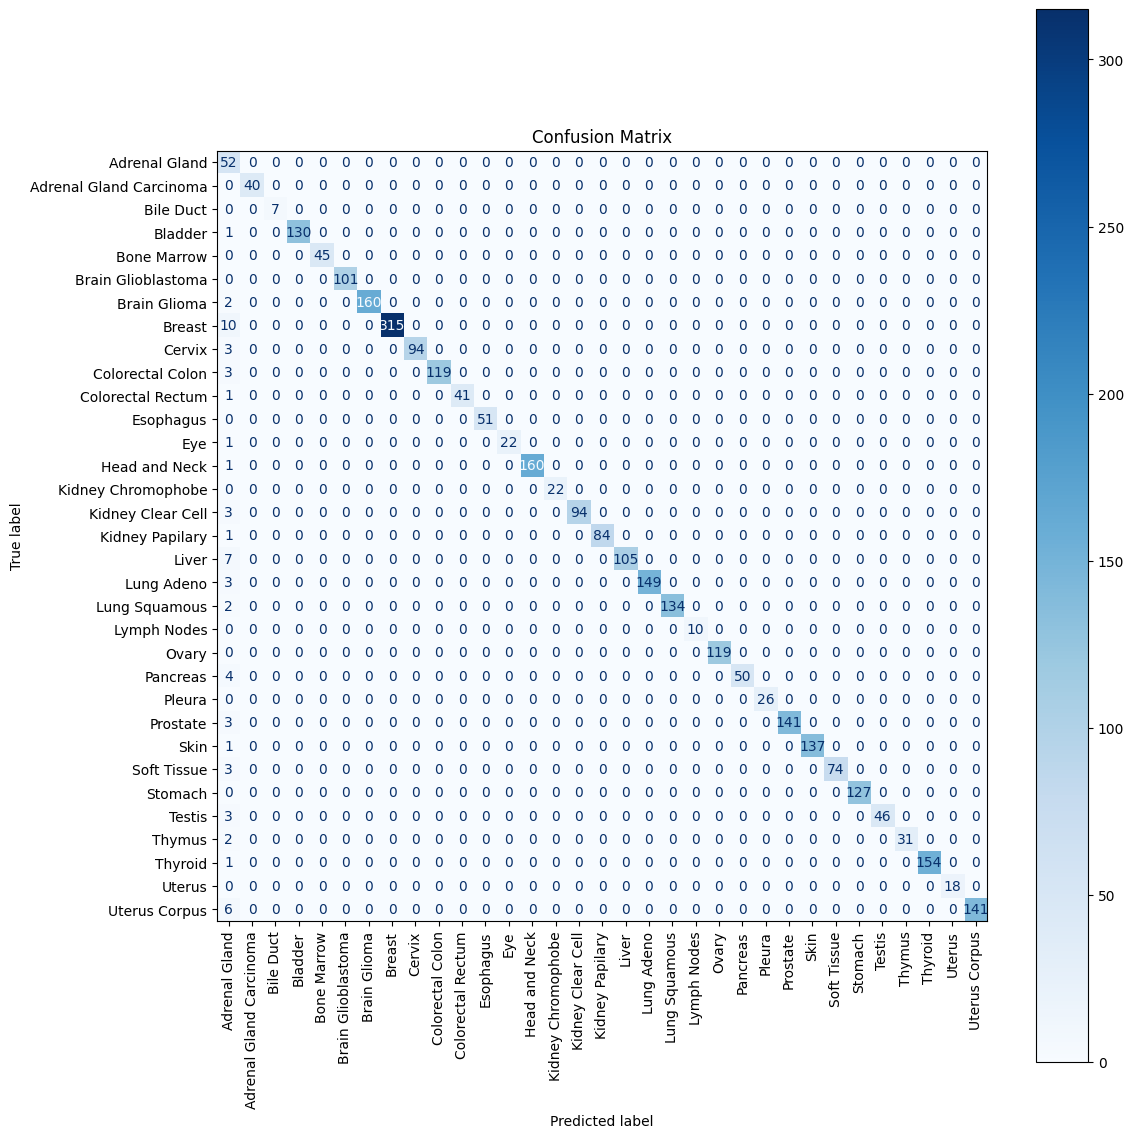

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Predict on test set
y_pred_bin = clf.predict(X_test)

# Convert binary outputs back to label indices
y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred_bin, axis=1))
y_true_labels = label_encoder.inverse_transform(np.argmax(y_test, axis=1))

# Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=label_encoder.classes_)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
